# &#x1F4D1; &nbsp;  Multi-Label Classification of Style Images

## &#x1F310; &nbsp; 0. Code Library, Style, and Links

In [1]:
%%html
<style> 
@import url('https://fonts.googleapis.com/css?family=Orbitron|Roboto');
body {background-color: gainsboro;} 
a {color: #37c9e1; font-family: 'Roboto';} 
h1 {color: #37c9e1; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;} 
h2, h3 {color: slategray; font-family: 'Orbitron'; text-shadow: 4px 4px 4px #ccc;}
h4 {color: #818286; font-family: 'Roboto';}
span {text-shadow: 4px 4px 4px #ccc;}
div.output_prompt, div.output_area pre {color: slategray;}
div.input_prompt, div.output_subarea {color: #37c9e1;}      
div.output_stderr pre {background-color: gainsboro;}  
div.output_stderr {background-color: slategrey;}       
</style>

In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model, Model
from keras.layers import Input, BatchNormalization
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers.advanced_activations import PReLU, LeakyReLU

from keras.applications.inception_v3 import InceptionV3, preprocess_input

import scipy
from scipy import misc


Using TensorFlow backend.


In [2]:
def history_plot(fit_history, n):
    plt.figure(figsize=(18, 12))
    
    plt.subplot(211)
    plt.plot(fit_history.history['loss'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_loss'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title('Loss Function');  
    
    plt.subplot(212)
    plt.plot(fit_history.history['acc'][n:], color='slategray', label = 'train')
    plt.plot(fit_history.history['val_acc'][n:], color='#4876ff', label = 'valid')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")    
    plt.legend()
    plt.title('Accuracy');

## &#x1F310; &nbsp; 1. Load and Explore the Data

In [3]:
data = pd.read_csv("/Users/olgabelitskaya/deep_learning_projects/DL_PP4/data/style.csv")
data.head()

,brand_name,brand_label,product_name,product_label,file
0,Christian Louboutin,0,shoes,0,0_0_001.png
1,Christian Louboutin,0,shoes,0,0_0_002.png
2,Christian Louboutin,0,shoes,0,0_0_003.png
3,Christian Louboutin,0,shoes,0,0_0_004.png
4,Christian Louboutin,0,shoes,0,0_0_005.png


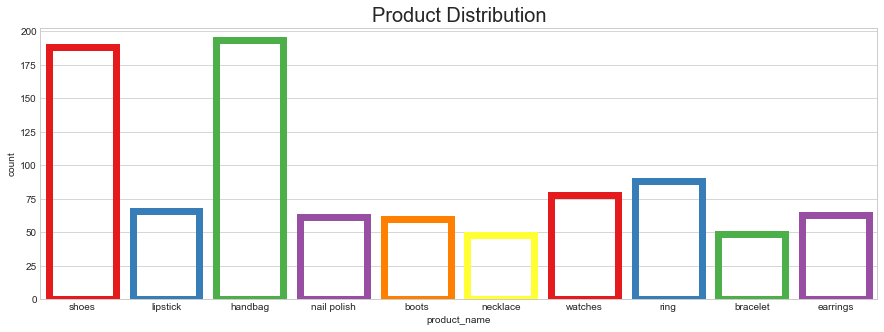

In [4]:
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(15,5))
sns.countplot(x="product_name", data=data,
              facecolor=(0, 0, 0, 0), linewidth=7,
              edgecolor=sns.color_palette("Set1"))
plt.title('Product Distribution', fontsize=20);

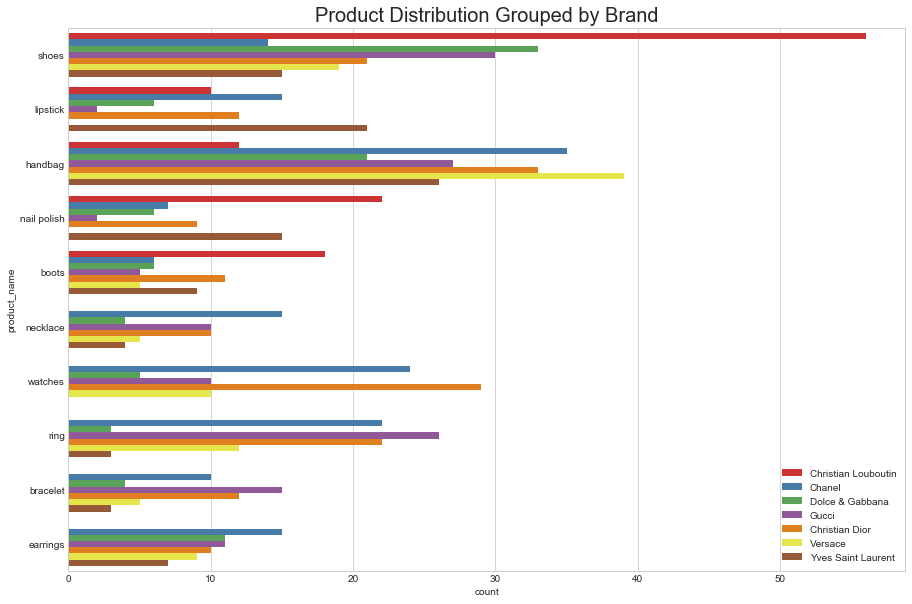

In [5]:
plt.figure(figsize=(15,10))
sns.countplot(y="product_name", hue="brand_name", data=data, palette='Set1')
plt.legend(loc=4)
plt.title('Product Distribution Grouped by Brand', 
          fontsize=20);

In [6]:
set(data['brand_name'])

{'Chanel',
 'Christian Dior',
 'Christian Louboutin',
 'Dolce & Gabbana',
 'Gucci',
 'Versace',
 'Yves Saint Laurent'}

In [7]:
set(data['product_name'])

{'boots',
 'bracelet',
 'earrings',
 'handbag',
 'lipstick',
 'nail polish',
 'necklace',
 'ring',
 'shoes',
 'watches'}

In [8]:
f = h5py.File('/Users/olgabelitskaya/deep_learning_projects/DL_PP4/StyleColorImages.h5', 'r')

keys = list(f.keys())
keys

['brands', 'images', 'products']

In [9]:
brands = np.array(f[keys[0]])
images = np.array(f[keys[1]])
products = np.array(f[keys[2]])

print ('Image shape:', images.shape)
print ('Brand shape', brands.shape)
print ('Product shape', products.shape)

Image shape: (894, 150, 150, 3)
Brand shape (894,)
Product shape (894,)


## &#x1F310; &nbsp; 2. Implement Preprocess Functions

In [10]:
images = images.astype('float32')/255

Product:  bracelet
Brand:  Gucci


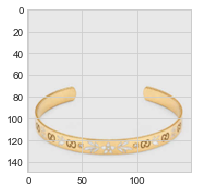

In [11]:
print('Product: ', data['product_name'][500])
print('Brand: ', data['brand_name'][500])
plt.figure(figsize=(3,3))
plt.imshow(images[500]);

In [12]:
gray_images = np.dot(images[...,:3], [0.299, 0.587, 0.114])
print ('Grayscaled Tensor shape:', gray_images.shape)

Grayscaled Tensor shape: (894, 150, 150)


Product:  bracelet
Brand:  Gucci


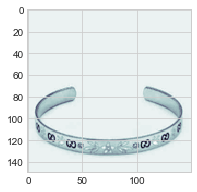

In [13]:
print('Product: ', data['product_name'][500])
print('Brand: ', data['brand_name'][500])
plt.figure(figsize=(3,3))
plt.imshow(gray_images[500], cmap=cm.bone);

In [14]:
print('Brands: ',set(brands), set(data['brand_name']))
print('Products: ',set(products), set(data['product_name']))

Brands:  {0, 1, 2, 3, 4, 5, 6} {'Yves Saint Laurent', 'Chanel', 'Versace', 'Dolce & Gabbana', 'Christian Dior', 'Christian Louboutin', 'Gucci'}
Products:  {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} {'necklace', 'earrings', 'ring', 'watches', 'lipstick', 'handbag', 'shoes', 'bracelet', 'boots', 'nail polish'}


In [15]:
cat_brands = to_categorical(brands, 7)
cat_products = to_categorical(products, 10)
cat_brands.shape, cat_products.shape

((894, 7), (894, 10))

In [16]:
targets = np.concatenate((cat_brands, cat_products), axis=1)
targets.shape

(894, 17)

In [17]:
# Color Images, Brand Target
x_train, x_test, y_train, y_test = train_test_split(images, cat_brands, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [18]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_valid.shape, y_valid.shape

((715, 150, 150, 3),
 (715, 7),
 (90, 150, 150, 3),
 (90, 7),
 (89, 150, 150, 3),
 (89, 7))

In [19]:
# Color Images, Product Target
x_train2, x_test2, y_train2, y_test2 = train_test_split(images, cat_products, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test2)/2)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [20]:
x_train2.shape, y_train2.shape, x_test2.shape, y_test2.shape, x_valid2.shape, y_valid2.shape

((715, 150, 150, 3),
 (715, 10),
 (90, 150, 150, 3),
 (90, 10),
 (89, 150, 150, 3),
 (89, 10))

In [21]:
# Color Images, Multi-Label Target
x_train3, x_test3, y_train3, y_test3 = train_test_split(images, targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test3)/2)
x_valid3, y_valid3 = x_test3[:n], y_test3[:n]
x_test3, y_test3 = x_test3[n:], y_test3[n:]

In [22]:
x_train3.shape, y_train3.shape, x_test3.shape, y_test3.shape, x_valid3.shape, y_valid3.shape

((715, 150, 150, 3),
 (715, 17),
 (90, 150, 150, 3),
 (90, 17),
 (89, 150, 150, 3),
 (89, 17))

In [ ]:
y_train3_list = [y_train3[:, :7], y_train3[:, 7:]]
y_test3_list = [y_test3[:, :7], y_test3[:, 7:]]
y_valid3_list = [y_valid3[:, :7], y_valid3[:, 7:]]

In [23]:
# Grayscaled Images, Brand Target
x_train4, x_test4, y_train4, y_test4 = train_test_split(gray_images, cat_brands, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test4)/2)
x_valid4, y_valid4 = x_test4[:n], y_test4[:n]
x_test4, y_test4 = x_test4[n:], y_test4[n:]

In [24]:
x_train4, x_test4, x_valid4 = \
x_train4.reshape(-1, 150, 150, 1), x_test4.reshape(-1, 150, 150, 1), x_valid4.reshape(-1, 150, 150, 1)

In [25]:
x_train4.shape, y_train4.shape, x_test4.shape, y_test4.shape, x_valid4.shape, y_valid4.shape

((715, 150, 150, 1),
 (715, 7),
 (90, 150, 150, 1),
 (90, 7),
 (89, 150, 150, 1),
 (89, 7))

In [26]:
# Grayscaled Images, Product Target
x_train5, x_test5, y_train5, y_test5 = train_test_split(gray_images, cat_products, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test5)/2)
x_valid5, y_valid5 = x_test5[:n], y_test5[:n]
x_test5, y_test5 = x_test5[n:], y_test5[n:]

In [27]:
x_train5, x_test5, x_valid5 = \
x_train5.reshape(-1, 150, 150, 1), x_test5.reshape(-1, 150, 150, 1), x_valid5.reshape(-1, 150, 150, 1)

In [28]:
x_train5.shape, y_train5.shape, x_test5.shape, y_test5.shape, x_valid5.shape, y_valid5.shape

((715, 150, 150, 1),
 (715, 10),
 (90, 150, 150, 1),
 (90, 10),
 (89, 150, 150, 1),
 (89, 10))

In [29]:
x_train6, x_test6, y_train6, y_test6 = train_test_split(gray_images, targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test6)/2)
x_valid6, y_valid6 = x_test6[:n], y_test6[:n]
x_test6, y_test6 = x_test6[n:], y_test6[n:]

In [30]:
x_train6, x_test6, x_valid6 = \
x_train6.reshape(-1, 150, 150, 1), x_test6.reshape(-1, 150, 150, 1), x_valid6.reshape(-1, 150, 150, 1)

In [31]:
x_train6.shape, y_train6.shape, x_test6.shape, y_test6.shape, x_valid6.shape, y_valid6.shape

((715, 150, 150, 1),
 (715, 17),
 (90, 150, 150, 1),
 (90, 17),
 (89, 150, 150, 1),
 (89, 17))

In [ ]:
y_train6_list = [y_train6[:, :7], y_train6[:, 7:]]
y_test6_list = [y_test6[:, :7], y_test6[:, 7:]]
y_valid6_list = [y_valid6[:, :7], y_valid6[:, 7:]]

## &#x1F310; &nbsp; 3. One-Label Classification Models

In [33]:
# Color Images, Brand Target
def cb_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cb_model = cb_model()

In [34]:
cb_checkpointer = ModelCheckpoint(filepath='cb_model.styles.hdf5', 
                                  verbose=2, save_best_only=True)
cb_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                    patience=5, verbose=2, factor=0.2)

In [35]:
cb_history = cb_model.fit(x_train, y_train, 
                          epochs=50, batch_size=16, verbose=2,
                          validation_data=(x_valid, y_valid),
                          callbacks=[cb_checkpointer,cb_lr_reduction])

Train on 715 samples, validate on 89 samples
Epoch 1/50
 - 172s - loss: 1.9575 - acc: 0.1678 - val_loss: 1.9148 - val_acc: 0.1798

Epoch 00001: val_loss improved from inf to 1.91479, saving model to cb_model.styles.hdf5
Epoch 2/50
 - 125s - loss: 1.9630 - acc: 0.1944 - val_loss: 1.9291 - val_acc: 0.1461

Epoch 00002: val_loss did not improve from 1.91479
Epoch 3/50
 - 123s - loss: 1.9255 - acc: 0.2070 - val_loss: 1.8943 - val_acc: 0.2584

Epoch 00003: val_loss improved from 1.91479 to 1.89432, saving model to cb_model.styles.hdf5
Epoch 4/50
 - 130s - loss: 1.8921 - acc: 0.2392 - val_loss: 1.8342 - val_acc: 0.2472

Epoch 00004: val_loss improved from 1.89432 to 1.83424, saving model to cb_model.styles.hdf5
Epoch 5/50
 - 129s - loss: 1.8802 - acc: 0.2462 - val_loss: 1.8499 - val_acc: 0.2360

Epoch 00005: val_loss did not improve from 1.83424
Epoch 6/50
 - 124s - loss: 1.8511 - acc: 0.2713 - val_loss: 1.7737 - val_acc: 0.2584

Epoch 00006: val_loss improved from 1.83424 to 1.77374, saving

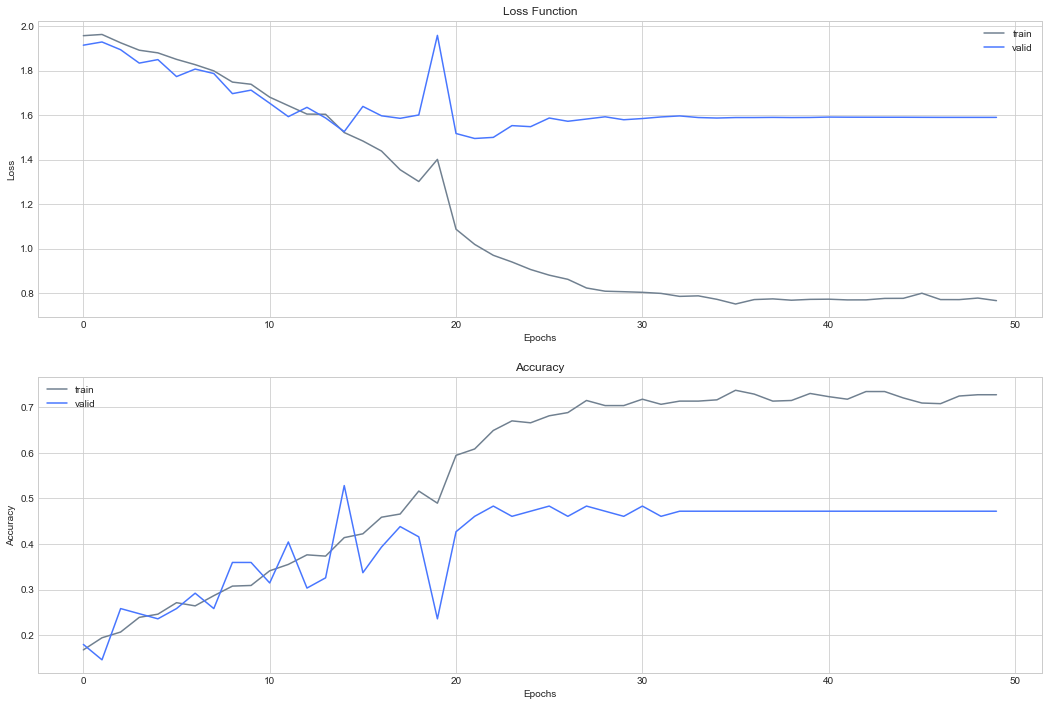

In [36]:
history_plot(cb_history, 0)

In [37]:
cb_model.load_weights('cb_model.styles.hdf5')

In [38]:
cb_score = cb_model.evaluate(x_test, y_test)
cb_score

90/90 [==============================] - 12s 132ms/step


[1.4747783290015326, 0.43333333532015483]

In [32]:
# Color Images, Product Target
def cp_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train2.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    
    return model

cp_model = cp_model()

In [33]:
cp_checkpointer = ModelCheckpoint(filepath='cp_model.styles.hdf5', 
                                  verbose=2, save_best_only=True)
cp_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                    patience=5, verbose=2, factor=0.2)

In [34]:
cp_history = cp_model.fit(x_train2, y_train2, 
                          epochs=50, batch_size=16, verbose=2,
                          validation_data=(x_valid2, y_valid2),
                          callbacks=[cp_checkpointer,cp_lr_reduction])

Train on 715 samples, validate on 89 samples
Epoch 1/50
 - 127s - loss: 2.1705 - acc: 0.2126 - val_loss: 2.0819 - val_acc: 0.2472

Epoch 00001: val_loss improved from inf to 2.08187, saving model to cp_model.styles.hdf5
Epoch 2/50
 - 138s - loss: 1.9918 - acc: 0.2629 - val_loss: 1.8726 - val_acc: 0.3483

Epoch 00002: val_loss improved from 2.08187 to 1.87258, saving model to cp_model.styles.hdf5
Epoch 3/50
 - 152s - loss: 1.8183 - acc: 0.3063 - val_loss: 1.7917 - val_acc: 0.3820

Epoch 00003: val_loss improved from 1.87258 to 1.79170, saving model to cp_model.styles.hdf5
Epoch 4/50
 - 149s - loss: 1.7276 - acc: 0.3930 - val_loss: 1.6497 - val_acc: 0.4494

Epoch 00004: val_loss improved from 1.79170 to 1.64968, saving model to cp_model.styles.hdf5
Epoch 5/50
 - 142s - loss: 1.6004 - acc: 0.4126 - val_loss: 1.6777 - val_acc: 0.4831

Epoch 00005: val_loss did not improve from 1.64968
Epoch 6/50
 - 143s - loss: 1.5581 - acc: 0.4364 - val_loss: 1.5699 - val_acc: 0.4719

Epoch 00006: val_los

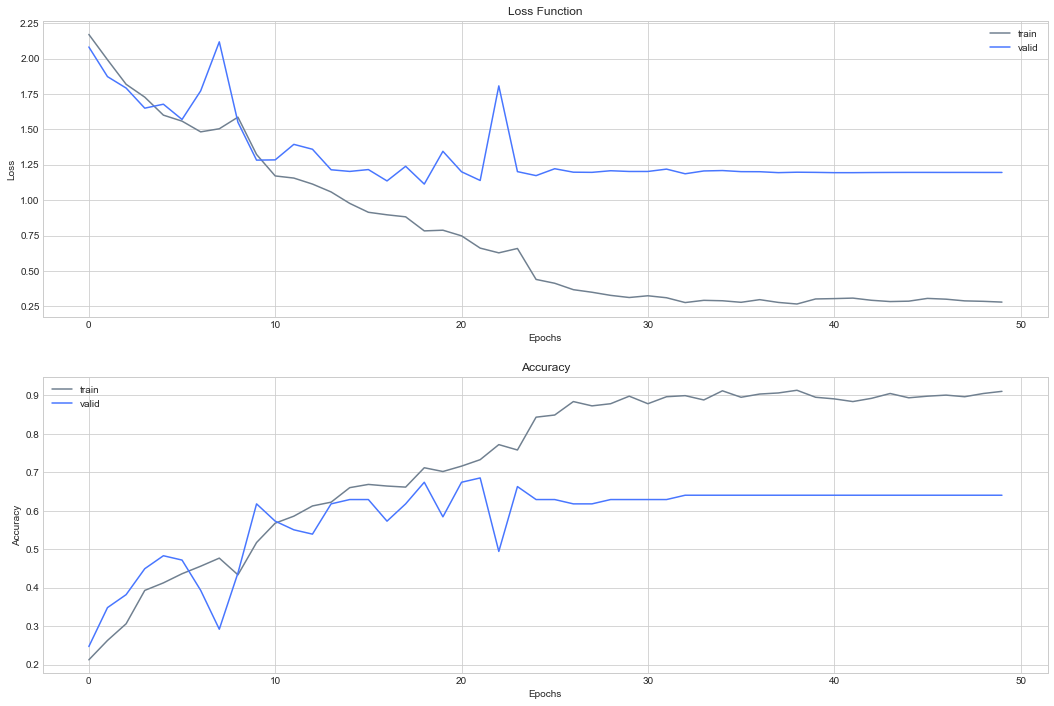

In [35]:
history_plot(cp_history, 0)

In [36]:
cp_model.load_weights('cp_model.styles.hdf5')

In [37]:
cp_score = cp_model.evaluate(x_test2, y_test2)
cp_score

90/90 [==============================] - 13s 141ms/step


[1.0602966136402554, 0.6666666719648573]

In [70]:
# Gray Scaled Images, Brand Target
def gray_cb_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train4.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(7))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

gray_cb_model = gray_cb_model()

In [71]:
gray_cb_checkpointer = ModelCheckpoint(filepath='gray_cb_model.styles.hdf5', 
                                       verbose=2, save_best_only=True)
gray_cb_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                         patience=5, verbose=2, factor=0.2)

In [72]:
gray_cb_history = gray_cb_model.fit(x_train4, y_train4, 
                                    epochs=50, batch_size=16, verbose=2,
                                    validation_data=(x_valid4, y_valid4),
                                    callbacks=[gray_cb_checkpointer,gray_cb_lr_reduction])

Train on 715 samples, validate on 89 samples
Epoch 1/50
 - 132s - loss: 1.9641 - acc: 0.1776 - val_loss: 1.9315 - val_acc: 0.1798

Epoch 00001: val_loss improved from inf to 1.93150, saving model to gray_cb_model.styles.hdf5
Epoch 2/50
 - 136s - loss: 1.9266 - acc: 0.1888 - val_loss: 1.9077 - val_acc: 0.2472

Epoch 00002: val_loss improved from 1.93150 to 1.90767, saving model to gray_cb_model.styles.hdf5
Epoch 3/50
 - 134s - loss: 1.9111 - acc: 0.2140 - val_loss: 1.8988 - val_acc: 0.1573

Epoch 00003: val_loss improved from 1.90767 to 1.89876, saving model to gray_cb_model.styles.hdf5
Epoch 4/50
 - 143s - loss: 1.9058 - acc: 0.2042 - val_loss: 1.8594 - val_acc: 0.1798

Epoch 00004: val_loss improved from 1.89876 to 1.85945, saving model to gray_cb_model.styles.hdf5
Epoch 5/50
 - 151s - loss: 1.8687 - acc: 0.2294 - val_loss: 1.8163 - val_acc: 0.2472

Epoch 00005: val_loss improved from 1.85945 to 1.81631, saving model to gray_cb_model.styles.hdf5
Epoch 6/50
 - 139s - loss: 1.8566 - acc

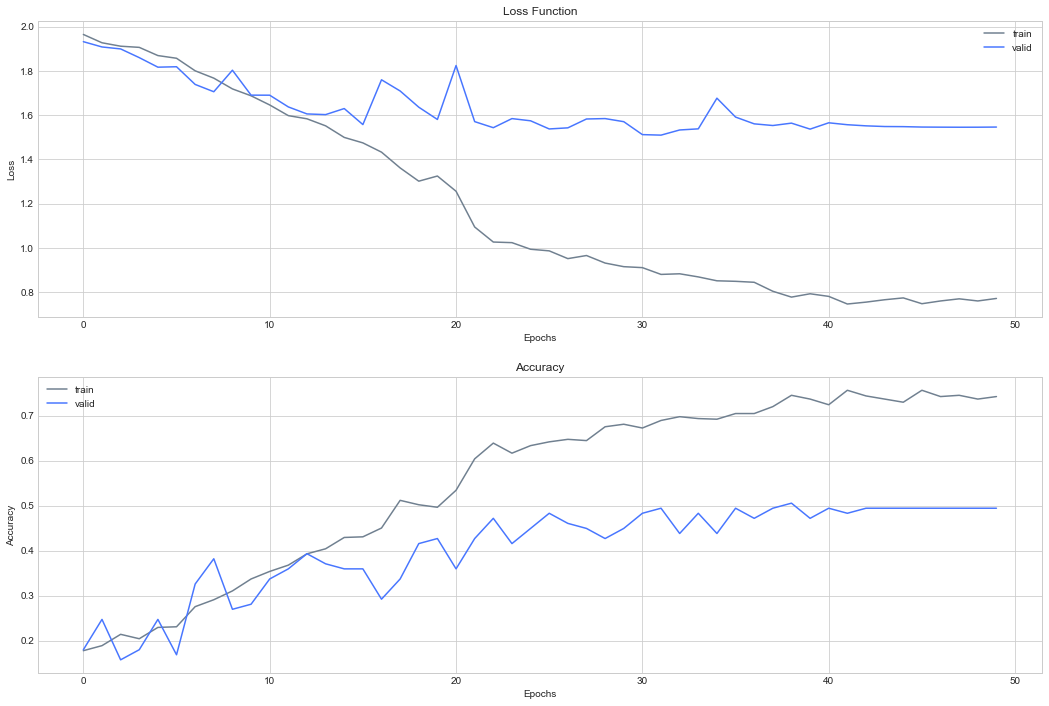

In [73]:
history_plot(gray_cb_history, 0)

In [74]:
gray_cb_model.load_weights('gray_cb_model.styles.hdf5')

In [75]:
gray_cb_score = gray_cb_model.evaluate(x_test4, y_test4)
gray_cb_score

90/90 [==============================] - 10s 113ms/step


[1.5431007358762954, 0.38888889021343653]

In [38]:
# Gray Scaled Images, Product Target
def gray_cp_model():
    model = Sequential()

    model.add(Conv2D(32, (5, 5), padding='same', input_shape=x_train5.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(196, (5, 5)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.2))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 
    
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    
    return model

gray_cp_model = gray_cp_model()

In [39]:
gray_cp_checkpointer = ModelCheckpoint(filepath='gray_cp_model.styles.hdf5', 
                                       verbose=2, save_best_only=True)
gray_cp_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                         patience=5, verbose=2, factor=0.2)

In [40]:
gray_cp_history = gray_cp_model.fit(x_train5, y_train5, 
                                    epochs=50, batch_size=16, verbose=2,
                                    validation_data=(x_valid5, y_valid5),
                                    callbacks=[gray_cp_checkpointer,gray_cp_lr_reduction])

Train on 715 samples, validate on 89 samples
Epoch 1/50
 - 143s - loss: 2.1698 - acc: 0.2042 - val_loss: 2.1144 - val_acc: 0.2247

Epoch 00001: val_loss improved from inf to 2.11439, saving model to gray_cp_model.styles.hdf5
Epoch 2/50
 - 107s - loss: 2.0148 - acc: 0.2545 - val_loss: 1.9993 - val_acc: 0.2809

Epoch 00002: val_loss improved from 2.11439 to 1.99928, saving model to gray_cp_model.styles.hdf5
Epoch 3/50
 - 125s - loss: 1.8989 - acc: 0.3161 - val_loss: 1.9726 - val_acc: 0.2921

Epoch 00003: val_loss improved from 1.99928 to 1.97264, saving model to gray_cp_model.styles.hdf5
Epoch 4/50
 - 114s - loss: 1.7742 - acc: 0.3566 - val_loss: 1.7743 - val_acc: 0.4719

Epoch 00004: val_loss improved from 1.97264 to 1.77433, saving model to gray_cp_model.styles.hdf5
Epoch 5/50
 - 154s - loss: 1.6486 - acc: 0.4042 - val_loss: 1.6804 - val_acc: 0.4494

Epoch 00005: val_loss improved from 1.77433 to 1.68044, saving model to gray_cp_model.styles.hdf5
Epoch 6/50
 - 139s - loss: 1.5241 - acc

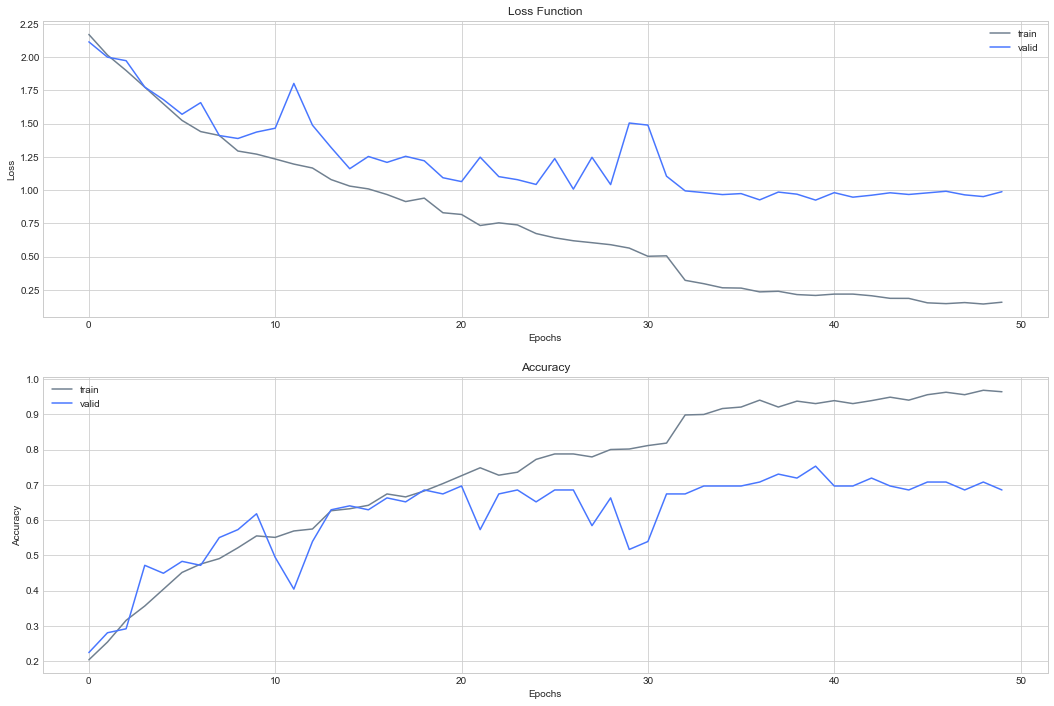

In [41]:
history_plot(gray_cp_history, 0)

In [42]:
gray_cp_model.load_weights('gray_cp_model.styles.hdf5')

In [43]:
gray_cp_score = gray_cp_model.evaluate(x_test5, y_test5)
gray_cp_score

90/90 [==============================] - 9s 102ms/step


[0.8592157986429002, 0.7666666626930236]

## &#x1F310; &nbsp; 4. Multi-Label Classification Models

In [ ]:
def multi_model():    
    model_input = Input(shape=(150, 150, 3))
    
    x = Conv2D(32, (5, 5),padding='same')(model_input)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
    
    x = Conv2D(196, (5, 5), padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)    
    x = Dropout(0.25)(x)
              
    x = GlobalMaxPooling2D()(x)
    
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.02)(x)
    x = Dropout(0.5)(x)
    
    y1 = Dense(7, activation='softmax')(x)
    y2 = Dense(10, activation='softmax')(x)
    
    model = Model(inputs=model_input, outputs=[y1, y2])

    model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
    return model

multi_model = multi_model()

In [ ]:
multi_checkpointer = ModelCheckpoint(filepath='multi_model.styles.hdf5', 
                                     verbose=2, save_best_only=True)
multi_lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                       patience=5, verbose=2, factor=0.2)

In [ ]:
multi_history = multi_model.fit(x_train3, y_train3_list, 
                                validation_data=(x_valid3, y_valid3_list), 
                                epochs=50, batch_size=16, verbose=2, 
                                callbacks=[multi_checkpointer,multi_lr_reduction])

In [ ]:
multi_model.load_weights('multi_model.styles.hdf5')

In [ ]:
multi_score = multi_model.evaluate(x_test3, y_test3_list, verbose=0)

print("Scores: \n" , (multi_score))
print("First label. Accuracy: %.2f%%" % (multi_score[3]*100))
print("Second label. Accuracy: %.2f%%" % (multi_score[4]*100))